In [3]:
import pandas as pd

filepath = "../data/Online Retail.xlsx"
df = pd.read_excel(filepath)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape
df.describe()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)

In [8]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [9]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [10]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [12]:
import datetime as dt

ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
})

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [ ]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,5,115
12347,2,7,4310.00,5,5,5,555
12348,75,4,1797.24,2,4,4,244
12349,19,1,1757.55,4,1,4,414
12350,310,1,334.40,1,1,2,112


In [14]:
def segment_customer(rfm):
    if rfm['R_Score'] >= 4 and rfm['F_Score'] >= 4 and rfm['M_Score'] >= 4:
        return 'Champions'
    elif rfm['R_Score'] >= 3 and rfm['F_Score'] >= 3:
        return 'Loyal Customers'
    elif rfm['R_Score'] >= 4:
        return 'Recent Customers'
    elif rfm['F_Score'] >= 4:
        return 'Frequent Buyers'
    elif rfm['M_Score'] >= 4:
        return 'Big Spenders'
    elif rfm['R_Score'] <= 2 and rfm['F_Score'] <= 2:
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

rfm.groupby('Segment').size().sort_values(ascending=False)


Segment
Loyal Customers     998
At Risk             987
Champions           962
Others              591
Recent Customers    319
Frequent Buyers     275
Big Spenders        206
dtype: int64

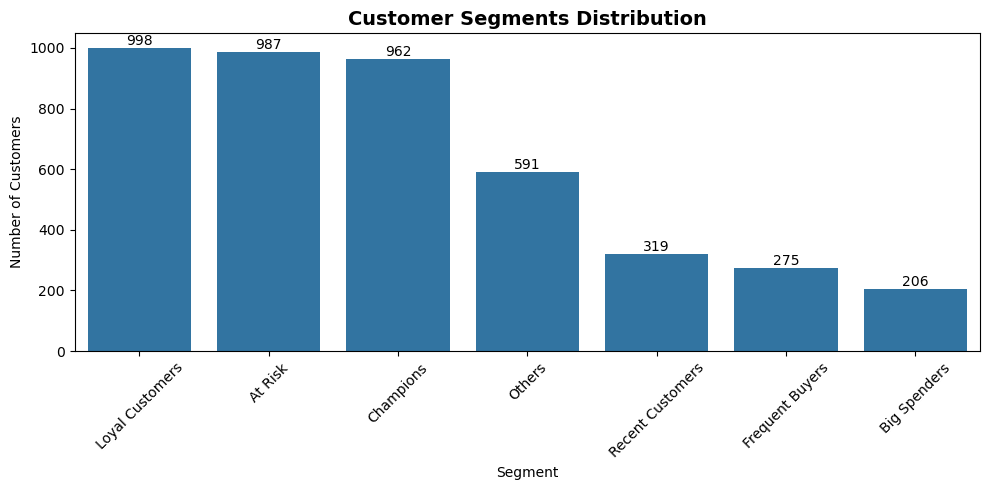

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ax = sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)

plt.title("Customer Segments Distribution", fontsize=14, weight='bold')
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [17]:
rfm_summary = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

rfm_summary


,Recency,Frequency,Monetary
Segment,,,
At Risk,220.7,1.1,301.4
Big Spenders,143.0,1.9,2494.4
Champions,12.9,11.1,6038.8
Frequent Buyers,137.1,4.9,1575.4
Loyal Customers,34.1,3.7,1477.1
Others,108.6,1.6,401.4
Recent Customers,18.5,1.2,458.2


In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', None)   # don't truncate cell text
pd.set_option('display.colheader_justify', 'center')  # center align headers

marketing_strategies = {
    "Segment": [
        "Champions",
        "Loyal Customers",
        "Recent Customers",
        "Frequent Buyers",
        "Big Spenders",
        "At Risk",
        "Others"
    ],
    "Description": [
        "Recent buyers, frequent purchases, spend a lot (best customers).",
        "Frequent buyers, not always top spenders.",
        "Bought very recently but not often (still new).",
        "Buy often, but not necessarily high spenders.",
        "High spend, but not very frequent.",
        "Used to buy often/spend a lot, but haven’t purchased in a while.",
        "Low across all dimensions (occasional, small purchases, or inconsistent)."
    ],
    "Suggested Actions": [
        "Exclusive/VIP offers, Early product launches, Referral incentives",
        "Loyalty programs, Personalized recommendations, Cross-selling/upselling",
        "Welcome emails, Discounts for 2nd purchase, Introduce bestsellers",
        "Bundle offers, Subscription deals, Reward points for frequency",
        "Premium product suggestions, Personal concierge service, Thank you gifts",
        "Re-engagement emails, Win-back discounts, Feedback surveys",
        "General promos, Seasonal offers, Awareness campaigns"
    ]
}

df_marketing = pd.DataFrame(marketing_strategies)

df_marketing


,Segment,Description,Suggested Actions
0,Champions,"Recent buyers, frequent purchases, spend a lot (best customers).","Exclusive/VIP offers, Early product launches, Referral incentives"
1,Loyal Customers,"Frequent buyers, not always top spenders.","Loyalty programs, Personalized recommendations, Cross-selling/upselling"
2,Recent Customers,Bought very recently but not often (still new).,"Welcome emails, Discounts for 2nd purchase, Introduce bestsellers"
3,Frequent Buyers,"Buy often, but not necessarily high spenders.","Bundle offers, Subscription deals, Reward points for frequency"
4,Big Spenders,"High spend, but not very frequent.","Premium product suggestions, Personal concierge service, Thank you gifts"
5,At Risk,"Used to buy often/spend a lot, but haven’t purchased in a while.","Re-engagement emails, Win-back discounts, Feedback surveys"
6,Others,"Low across all dimensions (occasional, small purchases, or inconsistent).","General promos, Seasonal offers, Awareness campaigns"


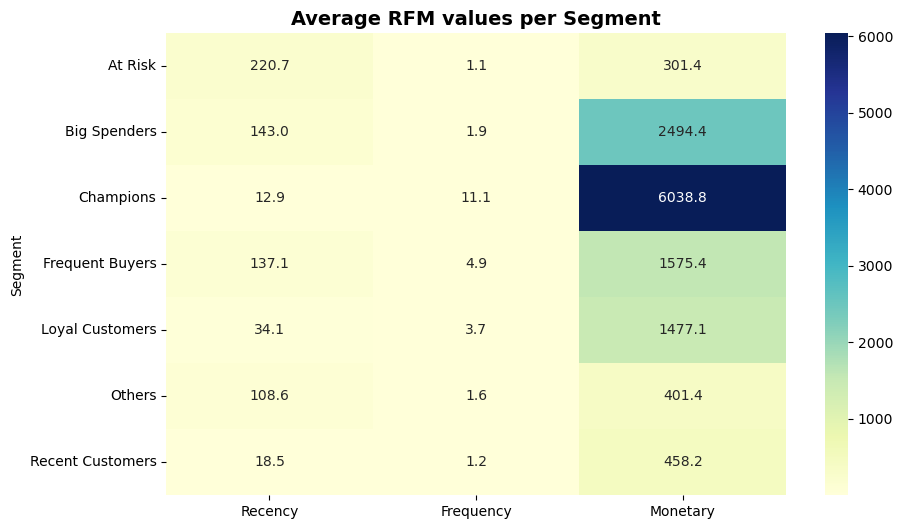

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

rfm_segment_summary = rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]].mean()

plt.figure(figsize=(10,6))
sns.heatmap(rfm_segment_summary, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM values per Segment", fontsize=14, weight='bold')
plt.show()

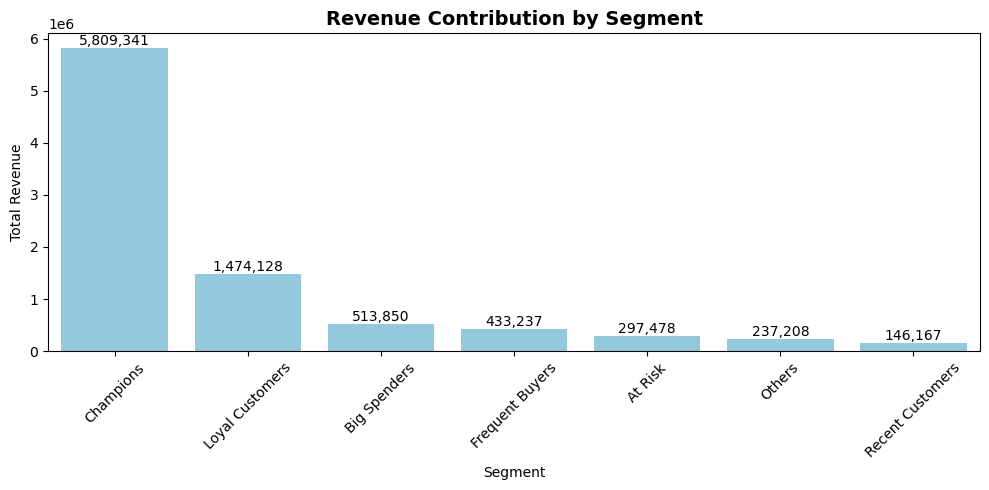

In [ ]:
segment_revenue = rfm.groupby("Segment")["Monetary"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=segment_revenue.index, y=segment_revenue.values, color="skyblue")

plt.title("Revenue Contribution by Segment", fontsize=14, weight='bold')
plt.ylabel("Total Revenue")
plt.xlabel("Segment")

for i, v in enumerate(segment_revenue.values):
    plt.text(i, v, f"{v:,.0f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


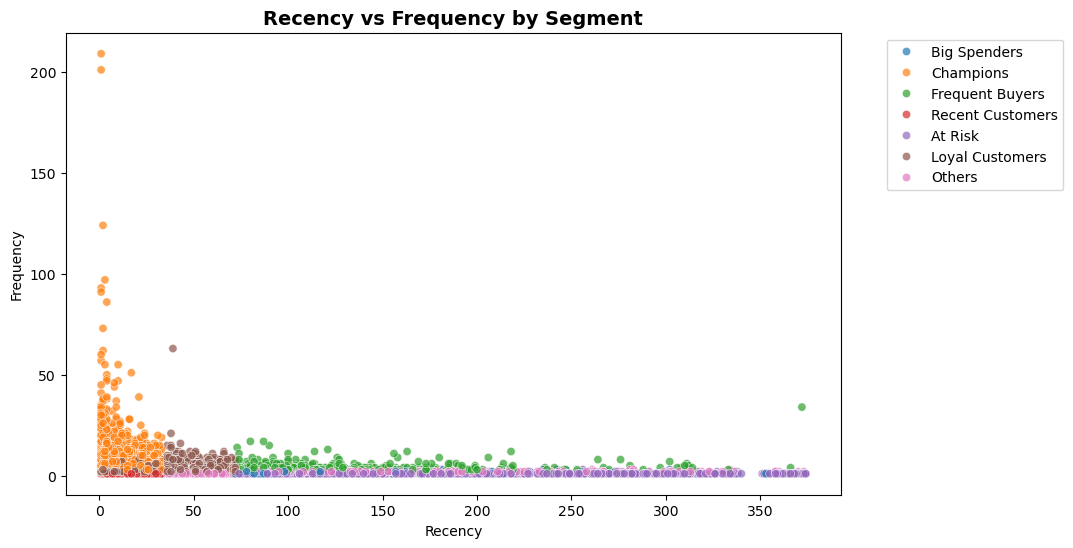

In [23]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="Segment", alpha=0.7)
plt.title("Recency vs Frequency by Segment", fontsize=14, weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()